# 가위바위보 분류기

### 데이터준비
+ 28x28 사이즈 변환


In [236]:
from PIL import Image
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import tensorflow as tf
from tensorflow import keras

import os

def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    print(len(images), " images to be resized.")
    
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
# train 가위바위보 이미지가 저장된 주소
PATH = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
image_dir_path1 = PATH
image_dir_path2 = PATH + "/rock"
image_dir_path3 = PATH + "/scissor"
image_dir_path4 = PATH + "/paper"

#test 가위바위보 이미지가 저장된주소
PATH2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
image_dir_path5 = PATH2
image_dir_path6 = PATH2 + "/rock"
image_dir_path7 = PATH2 + "/scissor"
image_dir_path8 = PATH2 + "/paper"

resize_images(image_dir_path2)
resize_images(image_dir_path3)
resize_images(image_dir_path4)

resize_images(image_dir_path6)
resize_images(image_dir_path7)
resize_images(image_dir_path8)

print("테스트 이미지 resize 완료!")


1000  images to be resized.
1000  images to be resized.
1000  images to be resized.
100  images to be resized.
100  images to be resized.
100  images to be resized.
테스트 이미지 resize 완료!


### test데이터 라벨링 및 정규화

In [237]:
def load_data(img_path,number_of_data=3000):    # 가위바위보 이미지 개수 총합
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    print("학습데이터(x_train)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

(x_train, y_train)=load_data(image_dir_path1)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 3000 입니다.
x_train shape: (3000, 28, 28, 3)
y_train shape: (3000,)


## 딥러닝 네트워크설계
+ Conv2D레이어,Dense레이어를 적당량 높여서 네트워크구축
+ dropout을 사용해서 오버피팅을 줄여본다.

In [238]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=12)

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 800)             

+  test 데이터 정규화

In [239]:
(x_test, y_test)=load_data(image_dir_path5,300)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test_norm.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


## 모델 성능평가
처음에는 300장 학습데이터로 시작했을때는 30%정도였는데   
#### 3000장으로 학습개수를 늘리고 정규화 이후 적합한 하이퍼파라미터들,dropout을 추가하는등 으로
### 76% 끌어올림

In [240]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 0.7638 - accuracy: 0.7700
test_loss: 0.7637717127799988 
test_accuracy: 0.7699999809265137


#### 잘못 예측된 데이터 확인
+ 주먹줬을때의 마디 때문에 보와 잘 구분을 못하는 것 같다

In [241]:
predicted_result = model.predict(x_test)  
predicted_labels = np.argmax(predicted_result, axis=1)

예측확률분포: [1.0000000e+00 1.0764184e-37 3.6703849e-38]
라벨: 2, 예측결과: 0


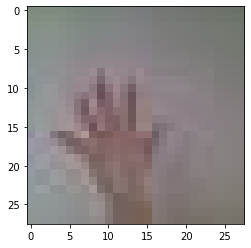

예측확률분포: [7.2751455e-28 0.0000000e+00 1.0000000e+00]
라벨: 0, 예측결과: 2


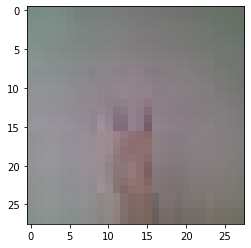

예측확률분포: [0. 0. 1.]
라벨: 1, 예측결과: 2


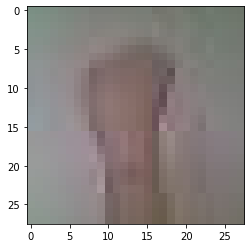

예측확률분포: [1.000000e+00 0.000000e+00 2.776985e-08]
라벨: 2, 예측결과: 0


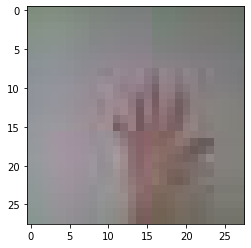

예측확률분포: [9.99890566e-01 0.00000000e+00 1.09445326e-04]
라벨: 2, 예측결과: 0


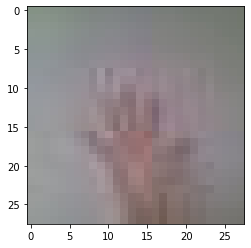

In [219]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모음
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑기
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

+ 많은량의 데이터셋의 확보 
+ 적합한 하이퍼파라미터
+ dropout 사용   
이 3가지가 컸었고 사실 데이터의 배경,빛,자세등이 달라서 쉽지가 않은것같다.

___
1. trainset 300장 testset 100장으로 시작했을때는 2~30퍼   
더 많은량의 데이터셋을 확보해서 trainset 3000장 trainset 300장으로 확률을 높였다.
___
2. 각각 배경, 조명등이 달라서 특징점을 많이 잡기위해  
Conv2D레이어,Dense레이어를 적당량 높여서 네트워크구축   
dropout을 사용해서 오버피팅을 줄여본다.
___
3. 학습횟수(epochs)를 늘려본다.
___
4. 60퍼가 넘게 나오게 되고 최대로 나온 확률이 76퍼였다.
___
